# Data Cleaning- Markov Chain
- CS109a Project: Data Driven March Madness
- Robert Shaw
- Kvam, P., & Sokol, J. S. (2006). "A Logistic Regression/Markov Chain Model for NCAA Basketball." Naval Research Logistics, 53(8), 788-803. doi:10.1002/nav.20170
See http://www2.isye.gatech.edu/~jsokol/ncaa.pdf


In this file, we model the NCAA as a Markov Chain. Each team is represented by a state. The current state of the chain is the current "best" team in the country. At each time step, the chain reeevaluates its choice. It chooses another state randomly, and transitions to the other state with probability $p$ and stays in the current state with probability $1 - p$. The probability $p$ is filled by answering the question, given that $i$ beat $j$ by $x$ in the regular season, what is the probability they are better. We will see below how we answer that questions. Thus, better teams will have a higher steady state probability, becuase they will have a lot of heavy edges coming into them. Thus, our ranking is a "PageRank"- analogue. See how we do it below.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# read datasets
regular_seasons = pd.read_csv("datasets/kaggle_data_2021/MRegularSeasonCompactResults.csv")
teams = pd.read_csv("datasets/kaggle_data_2021/MTeams.csv")

In [4]:
regular_seasons.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [5]:
# filtration function
def filter_season(data, season):
    return data[data["Season"] == season]
    
def filter_into_seasons(data):
    # buffer to hold list of seasons
    season_arr = []
    
    # min and max
    max_season = data["Season"].max()
    min_season = data["Season"].min()
    
    # filter
    for season in range(min_season, max_season + 1):
        season_arr.append(filter_season(data, season))
        
    return season_arr

In [6]:
# filtered seasons
seasons = filter_into_seasons(regular_seasons)

---

### 1) Create Home and Home Pairs

To see the transistion matrix, we need to find out the probability of being better giving a scoring difference $x$. To do this, we extract teams that played 2 times in a given year, and fit a logisitic model to the probability of a win in the second game, given the score in the first game. To do this, we first find all pairs of games.

Note: The code below is slow and not optimized.

In [11]:
home_and_home_list = []

i = 0
for season in seasons:
    print(i)
    
    for index, row in season.iterrows():
        w_team = row["WTeamID"]
        l_team = row["LTeamID"]
        w_loc  = row["WLoc"]
        
        # construct location
        if w_loc == "H":
            l_loc = "A"
        elif w_loc == "A":
            l_loc = "H"
        # ignore neutral site
        elif w_loc == "N":
            l_loc = "N/a"
            w_loc = "N/a"
            
        # wteam wins both 
        case_1 = ((season['WTeamID'] == w_team) & (season['LTeamID'] == l_team) & (season['WLoc'] == l_loc))
        # wteam wins one and lteam wins the other
        case_2 = ((season['WTeamID'] == l_team) & (season['LTeamID'] == w_team) & (season['WLoc'] == w_loc))
 
        # opposite home and home game
        games = season[(case_1 | case_2)].index
        
        # if there is a home and home
        if games.shape[0] > 0:
   
            # add to pairs list
            min_index = min(index, games.values[0])
            max_index = max(index, games.values[0])
            home_and_home_list.append((min_index, max_index))
    i+=1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [14]:
# generate pairs
home_and_home_pairs = pd.DataFrame(data = home_and_home_list, columns=["game1", "game2"])

In [15]:
home_and_home_pairs.to_csv("datasets/our_data/home_and_home_pairs_full.csv")

In [16]:
# drop dupicate rows
home_and_home_pairs_unique = home_and_home_pairs.drop_duplicates()

In [18]:
# test, see no more duplicates remain
print(home_and_home_pairs_unique[((home_and_home_pairs_unique['game1'] == 1)&(home_and_home_pairs_unique['game2'] == 1262))])

   game1  game2
0      1   1262


In [19]:
# export to csv
home_and_home = home_and_home_pairs_unique
home_and_home.to_csv("datasets/our_data/home_and_home_pairs.csv")

In [20]:
home_and_home = home_and_home_pairs_unique
home_and_home = home_and_home.reset_index(drop=True)

In [21]:
home_and_home["home_x"] = np.zeros(home_and_home.shape[0])
home_and_home["away_x"] = np.zeros(home_and_home.shape[0])

home_and_home.head()

,game1,game2,home_x,away_x
0,1,1262,0.0,0.0
1,4,1762,0.0,0.0
2,8,641,0.0,0.0
3,9,732,0.0,0.0
4,35,739,0.0,0.0


---

### 2) Get Home Team Results, Away Team Results
- Get the scoring differences to fill in the home_x, away_x cols.

In [23]:
# iterate games
for index, pair in home_and_home.iterrows():
    if index % 100 == 0:
        print(index)
    
    # games
    game_1 = regular_seasons.loc[pair[0]]
    game_2 = regular_seasons.loc[pair[1]]
    
    # game 1 scoring dif
    if game_1["WLoc"] == "H":
        # home team wins game 1
        game_1_dif = game_1["WScore"] - game_1["LScore"]
    else:
        # away team wins game 1
        game_1_dif = game_1["LScore"] - game_1["WScore"]
    
    # game 2 scoring dif
    if game_2["WLoc"] == "H":
        # home team wins game 2
        game_2_dif = game_2["LScore"] - game_2["WScore"]
    else:
        # away team wins game 2
        game_2_dif = game_2["WScore"] - game_2["LScore"]
    
    home_and_home.loc[index, "home_x"] = game_1_dif
    home_and_home.loc[index, "away_x"]= game_2_dif

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [24]:
home_and_home.head()

,game1,game2,home_x,away_x
0,1,1262,7.0,-5.0
1,4,1762,12.0,10.0
2,8,641,18.0,11.0
3,9,732,8.0,-9.0
4,35,739,45.0,-8.0


In [25]:
# convert to 0-1
home_and_home["away_win"] = np.zeros(home_and_home.shape[0])
for index, pair in home_and_home.iterrows():
    if pair["away_x"] > 0:
        home_and_home.loc[index, "away_win"] = 1
    else:
        home_and_home.loc[index, "away_win"] = 0

In [26]:
home_and_home.head()

,game1,game2,home_x,away_x,away_win
0,1,1262,7.0,-5.0,0.0
1,4,1762,12.0,10.0,1.0
2,8,641,18.0,11.0,1.0
3,9,732,8.0,-9.0,0.0
4,35,739,45.0,-8.0,0.0


In [27]:
home_and_home.to_csv("datasets/our_data/home_and_home_data.csv")

### 3) Fit Logistic Regression Model
- As described above, we model the probability of a win in the away game, given the home scoring difference of $x$.

In [29]:
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.model_selection import train_test_split

In [31]:
# train_x and train_y
train_x = home_and_home["home_x"].values.reshape((home_and_home.shape[0],1))
train_y = home_and_home["away_win"].values

# fit log_reg_model
log_reg_model = LogReg()
log_reg_model.fit(train_x, train_y)

print(log_reg_model.coef_)
print(log_reg_model.intercept_)

[[0.05386843]]
[-0.76691592]


/Users/dylanfarrell/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
from math import exp

In [36]:
# formatting for our graph
min_x = train_x.min()
max_x = train_x.max()

samp_prob = np.zeros(int(max_x) - int(min_x) + 1)
i = 0
for x in range(int(min_x), int(max_x) + 1):
    count = home_and_home[home_and_home["home_x"] == x]
    wins = count[count["away_win"] == 1]
    
    if count.shape[0] > 0:
        samp_prob[i] =  float(wins.shape[0]) / count.shape[0] 
        i = i + 1

In [37]:
# save so we do not have to run the code again
home_and_home.to_csv("datasets/our_data/sample_p_away_win_given_home_x.csv")

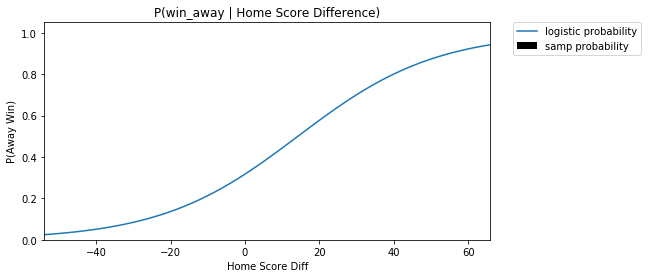

In [38]:
# init
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
min_x = train_x.min()
max_x = train_x.max()
x_values = np.array(range(int(min_x), int(max_x) + 1))

# calculate probabilities
odds = np.exp(x_values * log_reg_model.coef_ + log_reg_model.intercept_)
log_prob = odds / (1. + odds)

# plot
ax.plot(x_values, log_prob[0], label="logistic probability")
ax.bar(x_values, samp_prob, .005, color="black", label="samp probability")
ax.set_xlabel("Home Score Diff")
ax.set_ylabel("P(Away Win)")
ax.set_title("P(win_away | Home Score Difference)")
ax.set_xlim([min_x, max_x])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [39]:
# p win away given home scoring differential
x_values = np.array(range(-100, 101))
odds = np.exp((x_values) * log_reg_model.coef_ + log_reg_model.intercept_)
prob = odds / (1. + odds)      

s_x_h = pd.DataFrame(data=prob[0], index=x_values, columns=["prob"])

In [40]:
s_x_h.loc[14]

prob    0.496811
Name: 14, dtype: float64

We see s_x_h = .5 (P(win away | home scoring differential)) when x = 14.
Thus, home court advantage is 7 points.

In order to convert from P(win away | home scoring dif x), to P(better | home scoring dif x), we need to find the value of home court. We see that P(win away | home scoring dif x) = .5 when x = 14. So home court advantage is 7 points. Thus, P(better | home scoring dif 7) = .5 (and we shift all values by 7).

$r_x^H = s_{x+h}^H$ where $r_x^H$ = P(better | home scoring dif x) and  $s_{x+h}^H$ = P(win away | home scoring dif x) 

In [41]:
home_court_advantage = 7

In [42]:
x_values = np.array(range(-100, 101))
odds = np.exp((x_values + home_court_advantage) * log_reg_model.coef_ + log_reg_model.intercept_)
prob = odds / (1. + odds)                  
                    
probability_better_given_home_dif = prob

In [43]:
probability_better_given_home_dif_df = pd.DataFrame(data=probability_better_given_home_dif[0], index=x_values, columns=["prob"])

In [44]:
probability_better_given_home_dif_df.to_csv("datasets/our_data/r_x_h")

In [45]:
probability_better_given_home_dif_df.head()

,prob
-100,0.003089
-99,0.003260
-98,0.003440
-97,0.003629
-96,0.003829


In [46]:
# probability better given home dif of x 
r_x_h = probability_better_given_home_dif_df

$r_x^A = 1 - r_{-x}^H$  ---- P(better | away scoring dif x) = 1 - P(better | home scoring dif - x)

In [47]:
# probability better given away dif of x
# r_x_a = 1 - r_-x_h
helper_df = 1. - r_x_h
helper_df.index = range(100, -101, -1)
r_x_a = helper_df.sort_index()

In [48]:
r_x_a.to_csv("datasets/our_data/r_x_a")

$r_x^N = r_{x+h}^H = s_{x + 2h}^H$

In [49]:
# probability better given neutral dif of x
x_values = np.array(range(-100, 101))
odds_neutral = np.exp((x_values + 2 * home_court_advantage) * log_reg_model.coef_ + log_reg_model.intercept_)
prob_neutral = odds_neutral / (1. + odds_neutral)                  
                    
r_x_n = pd.DataFrame(data=prob_neutral[0], index=x_values, columns=["prob"])

In [50]:
r_x_n.to_csv("datasets/our_data/r_x_n")

### 4) Generate Markov Chain
- Given this Logisitic Regression Model for the transition probabilities, we now have to seed the markov chain. To do this, we need to get the results in each year of all possible matchups.

- Games Played Matrix

In [57]:
# counts of a teams wins and losses_
games_np = np.zeros((len(seasons), teams.shape[0]))

# iterate seasons
i = 0
for season in seasons:
    games = 0
    
    # count wins/losses
    win_counts = season["WTeamID"].value_counts(sort=False) 
    loss_counts = season["LTeamID"].value_counts(sort=False) 
    
    # iterate teams
    j = 0
    for team in range(teams["TeamID"].min(), teams["TeamID"].max() + 1):           
        # if a team has a win in the year, extract from wins count
        if team in win_counts.index:
            games = games + win_counts[team]
            
        # if a team has a loss in the year, extract from loss count
        if team in loss_counts.index:
            games = games + loss_counts[team]
        
        # update buffer
        if games == 0:
            games_np[i, j] = np.nan
        else:
            games_np[i, j] = games
                    
        j = j + 1
        
        games = 0
                    
    i = i + 1

In [61]:
games_matrix = pd.DataFrame(data=games_np, columns=teams["TeamID"], index=range(1985, 2021))

In [62]:
games_matrix.to_csv("datasets/our_data/games_matrix")

In [63]:
games_matrix.head()

TeamID,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,...,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471
1985,NaN,24.0,23.0,30.0,NaN,24.0,NaN,25.0,24.0,25.0,...,28.0,23.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,25.0,25.0,30.0,NaN,24.0,NaN,25.0,24.0,25.0,...,27.0,23.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,23.0,26.0,30.0,NaN,25.0,NaN,25.0,24.0,23.0,...,26.0,25.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,24.0,25.0,30.0,NaN,25.0,NaN,26.0,24.0,27.0,...,27.0,26.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,24.0,28.0,30.0,NaN,26.0,NaN,24.0,24.0,25.0,...,31.0,26.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Helper Functions

In [64]:
# extracts list of games between two teams
def get_games(games, team_1, team_2):
    
    # filter team 1 wins/ losses
    team_1_win = games[(games["WTeamID"] == team_1) & (games["LTeamID"] == team_2)]
    team_1_loss = games[(games["WTeamID"] == team_2) & (games["LTeamID"] == team_1)]
    
    # filter location
    team_1_win_home = team_1_win[(team_1_win["WLoc"] == "H")]
    team_1_win_away = team_1_win[(team_1_win["WLoc"] == "A")]
    team_1_win_neutral = team_1_win[(team_1_win["WLoc"] == "N")]
    
    # filter location
    team_1_loss_home = team_1_loss[(team_1_loss["WLoc"] == "A")]
    team_1_loss_away = team_1_loss[(team_1_loss["WLoc"] == "H")]
    team_1_loss_neutral = team_1_loss[(team_1_loss["WLoc"] == "N")]
    
    # get score differences
    home_games = get_score_difs(team_1_win_home, team_1_loss_home)
    away_games = get_score_difs(team_1_win_away, team_1_loss_away)
    neutral_games = get_score_difs(team_1_win_neutral, team_1_loss_neutral)
    
    return home_games, away_games, neutral_games
            

# given dfs of games, extract scoring differences
def get_score_difs(wins, losses):
    # buffer to hold values
    arr = []
    
    # iter wins
    for index, game in wins.iterrows():
        # calc score differences
        dif = game["WScore"] - game["LScore"]
        arr.append(dif)
        
    # iter losses
    for index, game in losses.iterrows():
        # calc score differences 
        dif = game["LScore"] - game["WScore"]
        arr.append(dif)
        
    return arr

# extract probs team 2 > team 1
def extract_rxs(score_difs, probs):
    rxs = []
    for dif in score_difs:

        # prob(team 2 > team 1) = 1 - prob(team 1 > team 2)
        rxs.append(1. - probs.loc[int(dif)])
        
    return rxs


- Gen Markov Chain Function

In [65]:
import math

In [66]:
# generate markov chain
def gen_markov_chain_transition_matrix(season, teams, games_count, home_rx_matrix, away_rx_matrix, neutral_rx_matrix):
    played_game = []
    # filter teams with 0 games played
    for i in range(teams.shape[0]):
        if math.isnan(games_count.iloc[i]):
            played_game.append(False)
        else:
            played_game.append(True)
    
    # indexes
    rows = teams[played_game]
    columns = rows
    
    # probability matrix
    probs_np = np.zeros((rows.shape[0], columns.shape[0]))
    probs_df = pd.DataFrame(data=probs_np, columns=columns, index=rows)
    
    # calculate t_{i,j} for all i != j
    for index, row in probs_df.iterrows():        
        # games played
        n_i = float(games_count.loc[index])
        
        # team 1
        team_1 = index

        # filter team 1's games
        team_1_games = season[(season["WTeamID"] == team_1) | (season["LTeamID"] == team_1)]
        opponents = np.unique(team_1_games[["WTeamID", "LTeamID"]])

        # iterate all opponents
        for team_2 in opponents:
            home_difs, away_difs, neutral_difs = get_games(team_1_games, team_1, team_2)        

            # check for 0
            if (home_difs, away_difs, neutral_difs) == (None, None, None):
                probs[i, team_2 - 1101] = 0.

            else:
                # get rxs (probability team 2 better than team 1, given score dif)
                home_rxs = extract_rxs(home_difs, home_rx_matrix)
                away_rxs = extract_rxs(away_difs, away_rx_matrix)
                neutral_rxs = extract_rxs(neutral_difs, neutral_rx_matrix)

                # transition probability
                probs_df.set_value(team_1, team_2, (sum(home_rxs) + sum(away_rxs) + sum(neutral_rxs)) / n_i)
        
    # calculate t_{i,i}
    for index, row in probs_df.iterrows():
        team_1 = index
        
        # games played
        n_i = float(games_count.loc[index])

        # t_ii = 1 - sum_{j} t_ij
        probs_df.set_value(team_1, team_1, 1. - probs_df.loc[team_1, :].sum())
            
    return probs_df     

- Gen Stationary Distribution --> $\pi P = \lambda \pi$ (the first eigenvector is the steady state distribution)

In [67]:
from scipy.linalg import eig

In [69]:
# generate stationary distibution
def generate_stationary_distribution(probs, teams, games):
    eigenvalues, eigenvectors = eig(probs,left=True,right=False)

    # stationary distibution is primary eigenvector
    # pi = pi * P
    stationary = eigenvectors[:, 0]
    stationary = stationary / np.sum(stationary)
    
    # confirm it works
    if stationary[np.iscomplex(stationary)].shape[0] == 0:
        # convert to reals
        stationary = stationary.astype(float)
    else:
        print("complex!!")

    played_game = []
    # filter teams with 0 games played
    for i in range(teams.shape[0]):
        if math.isnan(games.iloc[i]):
            played_game.append(False)
        else:
            played_game.append(True)

    # indexes of dataframe are only those teams who played games
    indexes = teams[played_game]["TeamID"].values

    print(indexes.shape)
    print(stationary.shape)
    # return dataframe
    return pd.DataFrame(data=stationary, index = indexes, columns =["pi_i"])

- Test Code on 1985

In [71]:
probs_1985 = gen_markov_chain_transition_matrix(seasons[0], teams["TeamID"], games_matrix.iloc[0, :], r_x_h, r_x_a, r_x_n)

/Users/dylanfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dylanfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [72]:
stationary_1985_df = generate_stationary_distribution(probs_1985, teams, games_matrix.iloc[0, :])

(282,)
(282,)


/Users/dylanfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


In [73]:
stationary_1985_df.head()

,pi_i
1102,0.001993
1103,0.002048
1104,0.006740
1106,0.002100
1108,0.004175


In [74]:
# confirm sums to 1
stationary_1985_df.sum()

pi_i    1.0
dtype: float64

See if there is any predictive power with a crude data exploration.

In [76]:
tourney_wins = pd.read_csv("datasets/our_data/team_summary_data/tourney_wins_matrix", index_col=0)
in_tourney = pd.read_csv("datasets/our_data/team_summary_data/in_tourney_matrix", index_col=0)

In [77]:
from sklearn.linear_model import LinearRegression as LinReg

In [78]:
in_tourney_1985 = in_tourney.loc[1985]
teams_in_tourney_1985 = in_tourney_1985[in_tourney_1985 == 1.].index

In [79]:
tourney_wins_1985_filt = tourney_wins.loc[1985, teams_in_tourney_1985]

In [80]:
pi_i_1985 = pd.read_csv("datasets/our_data/markov_data/1985_stationary_distribution", index_col=0)

pi_i_1985.index = pi_i_1985.index.astype(str)
pi_i_1985_filt = pi_i_1985.loc[teams_in_tourney_1985, "pi_i"]

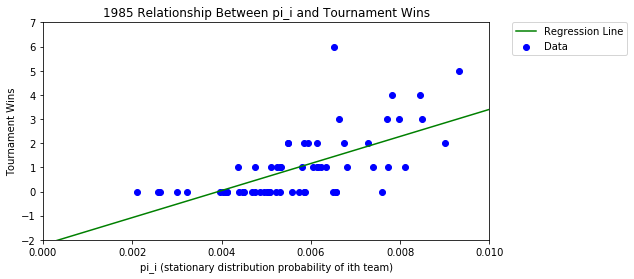

In [81]:
lin_reg = LinReg()
y = tourney_wins_1985_filt.values.reshape(64,1)
x = pi_i_1985_filt.values.reshape(64,1)
lin_reg.fit(x,y)


x_vals = np.array([0, .01])
y_vals = x_vals * lin_reg.coef_[0] + lin_reg.intercept_

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.scatter(x, y, color="Blue", label="Data")
ax.plot(x_vals, y_vals, color="green", label="Regression Line")
ax.set_xlim([0, .01])
ax.set_ylim([-2,7])
ax.set_title("1985 Relationship Between pi_i and Tournament Wins")
ax.set_xlabel("pi_i (stationary distribution probability of ith team)")
ax.set_ylabel("Tournament Wins")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

There appears to be a strong relationship between our predictor and the number of tournament wins. As such, this predictor should be powerful in our heaad to head model.

### 5) Gen Transition Matrix For All Years
- After confirming everything works for 1985, we will do it for all 31 years.
- Note: This code is very slow, but only needs to be run once. Should take ~15 mins to generate all years. I accidentally cleared all of the cells, and am not going to run this again.

In [83]:
transition_matricies = []
stationary_distributions = []

i = 1985
for season in seasons:
    # generate transition matrix
    transition_matrix_df = gen_markov_chain_transition_matrix(season, teams["TeamID"], games_matrix.iloc[i - 1985, :], r_x_h, r_x_a, r_x_n)
    
    # save as a file
    file_path = "datasets/our_data/markov_data/{}_transition_matrix".format(i)
    transition_matrix_df.to_csv(file_path)
    
    # append to list
    transition_matricies.append(transition_matrix_df)
    
    # generate stationary distibution
    stationary_df = generate_stationary_distribution(transition_matrix_df, teams, games_matrix.iloc[i - 1985, :])
    
    # save as a file
    file_path = "datasets/our_data/markov_data/{}_stationary_distribution".format(i)
    stationary_df.to_csv(file_path)
    
    # append to list
    stationary_distributions.append(stationary_df)
    
    print(stationary_df.sum())
      
    i = i + 1 

/Users/dylanfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dylanfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dylanfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


(282,)
(282,)
pi_i    1.0
dtype: float64
(283,)
(283,)
pi_i    1.0
dtype: float64
(290,)
(290,)
pi_i    1.0
dtype: float64
(290,)
(290,)
pi_i    1.0
dtype: float64
(293,)
(293,)
pi_i    1.0
dtype: float64
(292,)
(292,)
pi_i    1.0
dtype: float64
(295,)
(295,)
pi_i    1.0
dtype: float64
(298,)
(298,)
pi_i    1.0
dtype: float64
(298,)
(298,)
pi_i    1.0
dtype: float64
(301,)
(301,)
pi_i    1.0
dtype: float64
(302,)
(302,)
pi_i    1.0
dtype: float64
(305,)
(305,)
pi_i    1.0
dtype: float64
(305,)
(305,)
pi_i    1.0
dtype: float64
(306,)
(306,)
pi_i    1.0
dtype: float64
(310,)
(310,)
pi_i    1.0
dtype: float64
(318,)
(318,)
pi_i    1.0
dtype: float64
(318,)
(318,)
pi_i    1.0
dtype: float64
(321,)
(321,)
pi_i    1.0
dtype: float64
(327,)
(327,)
pi_i    1.0
dtype: float64
(326,)
(326,)
pi_i    1.0
dtype: float64
(330,)
(330,)
pi_i    1.0
dtype: float64
(334,)
(334,)
pi_i    1.0
dtype: float64
(336,)
(336,)
pi_i    1.0
dtype: float64
(342,)
(342,)
pi_i    1.0
dtype: float64
(347,)
(347,)
pi

#### Vert Crude Train-Test Split ---> we end up using a windowing approach ---> see Modeling-Model Seleciton Page

In [84]:
import random

In [85]:
i = 1985
j = 0 
cutoff = .7

preds_train = []
resps_train = []

preds_cross = []
resps_cross = []

# crude train test split
for season in seasons:
    # filter tourney wins
    cur_season_in_tourney = in_tourney.loc[i][in_tourney.loc[i] == 1].index
    cur_season_tourney_wins = tourney_wins.loc[i, cur_season_in_tourney]
    
    # filter current 
    pi = stationary_distributions[j].loc[cur_season_in_tourney.astype(int)]
    
    if random.uniform(0,1) < .7:
        preds_train.append(pi)
        resps_train.append(cur_season_tourney_wins)
    else:
        preds_cross.append(pi)
        resps_cross.append(cur_season_tourney_wins) 
    
    i = i + 1
    j = j + 1

KeyError: 2017

In [ ]:
# train test split
x_train = pd.concat(preds_train).values
y_train = pd.concat(resps_train).values
x_train = x_train.reshape(x_train.shape[0],1)
y_train = y_train.reshape(y_train.shape[0],1)

x_cross = pd.concat(preds_cross).values
y_cross = pd.concat(resps_cross).values
x_cross = x_cross.reshape(x_cross.shape[0],1)
y_cross = y_cross.reshape(y_cross.shape[0],1)

# fit model to test
lin_reg = LinReg()
lin_reg.fit(x_train,y_train)
test_r2 = lin_reg.score(x_cross, y_cross)

# line to plot
x_vals = np.array([0, .02])
y_vals = x_vals * lin_reg.coef_[0] + lin_reg.intercept_

# init plot
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

# scatter and plot line
ax.scatter(x_cross, y_cross, color="Blue", label="Test Data Points", alpha=.5)
ax.plot(x_vals, y_vals, color="green", label="Regression Line")

# format axis
ax.set_xlim([.001, .012])
ax.set_ylim([-1,7])
ax.set_title("$\pi_i$ vs. Tournament Wins, test r^2 = {}".format(round(test_r2, 2)))
ax.set_xlabel("pi_i (stationary distribution probability of ith team)")
ax.set_ylabel("Tournament Wins")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)